In [53]:
import torch
import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from random import randrange
from torchvision.utils import make_grid
from torch.utils.data import Subset, DataLoader
import torchvision.transforms.functional as F
import numpy as np

Load Dataset

In [54]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [55]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [56]:
cifar_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform)

In [57]:
IDX_TO_LABEL = {v: k for k, v in cifar_dataset.class_to_idx.items()}

In [58]:
IDX_TO_LABEL

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [59]:
def show_image(img):
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

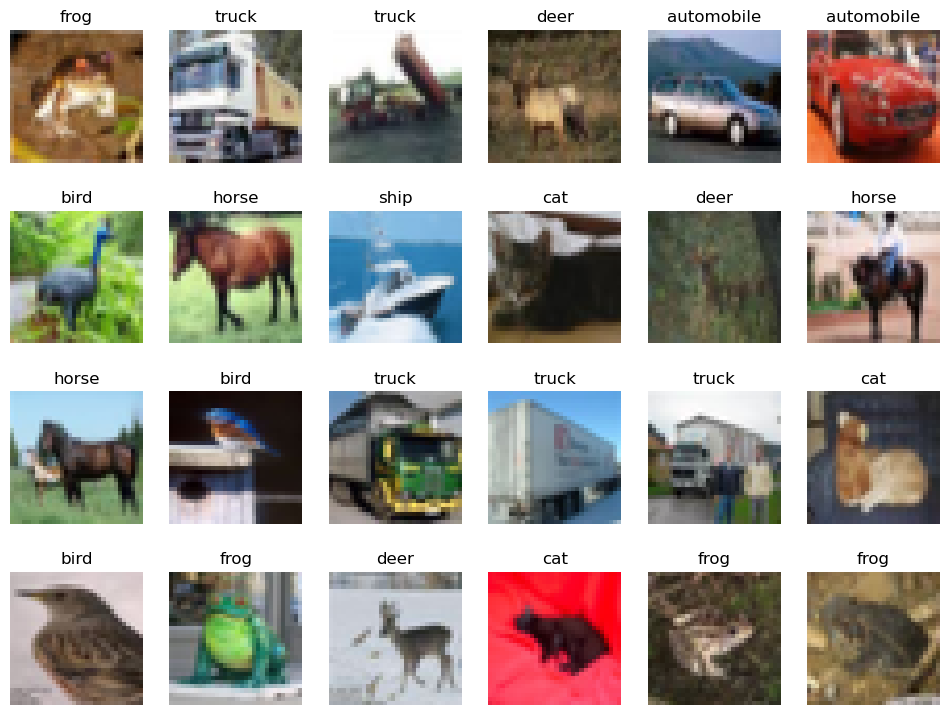

In [60]:
cols = 6
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(12,9))
smpl_idx = 0
for x in range(rows):
    for y in range(cols):
        axs[x, y].set_title(IDX_TO_LABEL[cifar_dataset.targets[smpl_idx]])
        axs[x, y].imshow(cifar_dataset.data[smpl_idx])
        smpl_idx += 1
        axs[x, y].set_axis_off()

plt.show()

In [61]:
cat_idx=[i for i,x in enumerate(cifar_dataset.targets) if x==3]

In [62]:
cat_subset = Subset(cifar_dataset, cat_idx)

In [63]:
cat_data = cat_subset.dataset.data[cat_idx[:16]]

In [64]:
cat_data.shape

(16, 32, 32, 3)

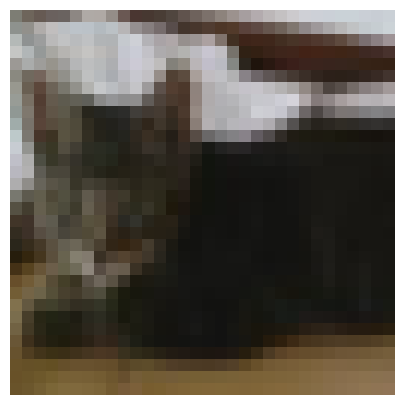

In [65]:
show_image(transforms.ToPILImage()(cat_data[0]))

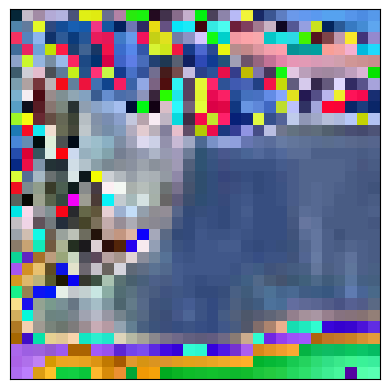

In [66]:
show(cat_subset[0][0])

In [67]:
cat_loader = DataLoader(cat_subset, 16)

In [68]:
cat_batch = next(iter(cat_loader))

In [69]:
grid = make_grid(cat_batch[0], nrow=4)

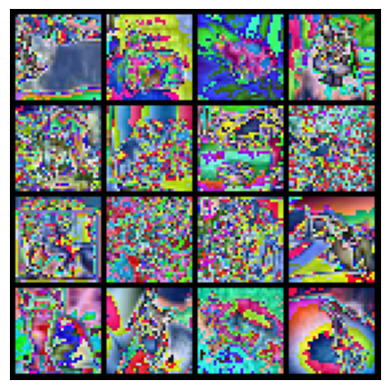

In [70]:
show(grid)

Load Model

MOE

In [71]:
checkpoint = torch.load('/media/aristo/Data A/documents/kuliah/Project/CAM/checkpoint/cifar-CAM_Moe1_resnet32_5vK6SrW58X/ckpt.best.pth.tar')

In [72]:
model = models.__dict__[checkpoint['arch']](backbone='resnet32')

In [73]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [74]:
checkpoint['state_dict']

OrderedDict([('backbone.conv1.weight',
              tensor([[[[ 1.6082e-01, -5.5932e-03,  1.1075e-03],
                        [-1.5840e-01, -6.1813e-01,  7.4160e-01],
                        [ 1.5469e-01, -1.4000e-01,  4.3861e-02]],
              
                       [[-1.2838e-01, -2.9047e-01,  1.1573e-01],
                        [-5.0036e-01, -7.8931e-01,  1.1921e+00],
                        [ 1.5709e-02, -1.3486e-01,  3.1933e-01]],
              
                       [[-8.9869e-02, -2.0331e-01,  2.8506e-01],
                        [-4.8303e-01, -5.5400e-01,  1.3776e+00],
                        [-3.2084e-01, -3.0518e-01,  4.6899e-01]]],
              
              
                      [[[ 1.0946e-01, -5.2646e-02,  5.9233e-02],
                        [-1.1864e-01, -7.5805e-01, -5.1606e-01],
                        [-1.0390e-01, -8.0276e-01, -3.6494e-01]],
              
                       [[ 9.0807e-02,  9.4369e-02,  9.7133e-02],
                        [-8.9226e-02

In [75]:
model

Moe1(
  (backbone): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2)

Grad-Cam

In [76]:
from torchcam.methods import GradCAM

In [77]:
from torchcam.utils import overlay_mask

In [78]:
model.eval()

Moe1(
  (backbone): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2)

In [79]:
gradcam = GradCAM(model, model.backbone.layer3, (3, 32, 32))

In [80]:
cat_tensor = cat_batch[0][0].unsqueeze(0)

In [81]:
out = model(cat_tensor)

In [82]:
prediction_idx = out.squeeze(0).argmax().item()

In [83]:
activation_map = gradcam(prediction_idx, out)

In [84]:
activation_map[0].shape

torch.Size([1, 8, 8])

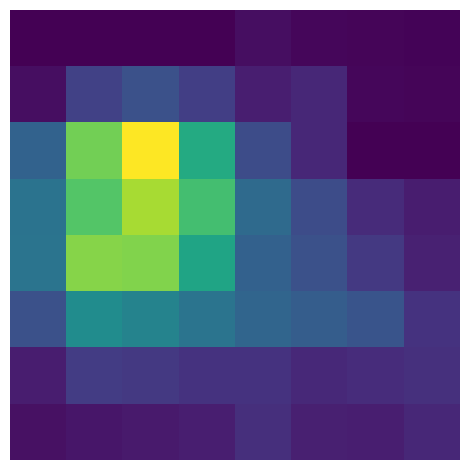

In [85]:
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout()

In [86]:
result = overlay_mask(transforms.ToPILImage()(cat_data[0]),transforms.ToPILImage(mode='F')(activation_map[0].squeeze(0)), alpha=0.7)

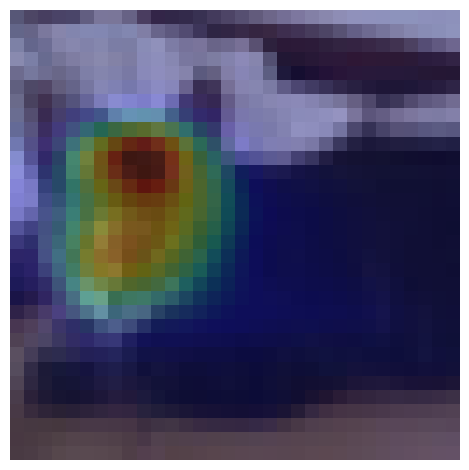

In [87]:
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

vanilla

In [88]:
class WrappedModel(torch.nn.Module):
	def __init__(self, module):
		super(WrappedModel, self).__init__()
		self.module = module # that I actually define.
	def forward(self, x):
		return self.module(x)

In [89]:
vanilla = WrappedModel(models.resnet32())

In [90]:
vanilla

WrappedModel(
  (module): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [91]:
vanila_chkp = torch.load('/media/aristo/Data A/documents/kuliah/Project/CAM/log/10/resnet32-d509ac18.th')

In [92]:
vanilla.load_state_dict(vanila_chkp['state_dict'])

<All keys matched successfully>

In [93]:
vanilla.eval()

WrappedModel(
  (module): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [94]:
gradcam = GradCAM(vanilla, vanilla.module.layer3, (3, 32, 32))

In [95]:
out_vanilla= vanilla(cat_tensor)

In [96]:
prediction_idx_vanilla = out_vanilla.squeeze(0).argmax().item()

In [97]:
activation_map_vannila = gradcam(prediction_idx_vanilla, out_vanilla)

In [98]:
result_vannila = overlay_mask(transforms.ToPILImage()(cat_data[0]),transforms.ToPILImage(mode='F')(activation_map_vannila[0].squeeze(0)), alpha=0.7)

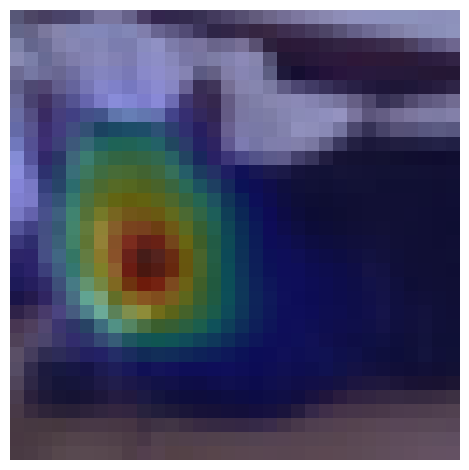

In [99]:
plt.imshow(result_vannila); plt.axis('off'); plt.tight_layout(); plt.show()

Lorot

In [100]:
lorot = models.Lorot()
lorot.eval()

Lorot(
  (backbone): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2

In [101]:
lorot_chkp = torch.load('/media/aristo/Data A/documents/kuliah/Project/CAM/checkpoint/cifar-CAM_Lorot_resnet32_nJmodpRnq5/ckpt.pth.tar')

In [102]:
lorot.load_state_dict(lorot_chkp['state_dict'])

<All keys matched successfully>

In [103]:
gradcam = GradCAM(lorot, lorot.backbone.layer3, (3, 32, 32))

In [104]:
out_lorot = lorot(cat_tensor)
prediction_idx_lorot = out_lorot.squeeze(0).argmax().item()

In [105]:
activation_map_lorot = gradcam(prediction_idx_lorot, out_lorot)

In [108]:
result_lorot = overlay_mask(transforms.ToPILImage()(cat_data[0]),transforms.ToPILImage(mode='F')(activation_map_lorot[0].squeeze(0)), alpha=0.7)

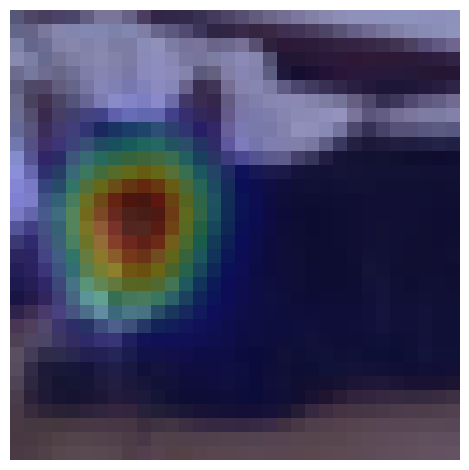

In [109]:
plt.imshow(result_lorot); plt.axis('off'); plt.tight_layout(); plt.show()

nomoe

In [110]:
nomoe = models.Nomoe()

In [111]:
nomoe_ckpt = torch.load('/media/aristo/Data A/documents/kuliah/Project/CAM/checkpoint/cifar-CAM_Nomoe_resnet32_pOcgjojCCE/ckpt.pth.tar')

In [112]:
nomoe.load_state_dict(nomoe_ckpt['state_dict'])

<All keys matched successfully>

In [113]:
nomoe.eval()

Nomoe(
  (backbone): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2

In [114]:
gradcam = GradCAM(nomoe, nomoe.backbone.layer3, (3,32,32))

In [115]:
out_nomoe = nomoe(cat_tensor)

In [116]:
prediction_idx_nomoe = out_nomoe.squeeze(0).argmax().item()

In [117]:
activation_map_nomoe = gradcam(prediction_idx_nomoe, out_nomoe)

In [118]:
result_nomoe = overlay_mask(transforms.ToPILImage()(cat_data[0]),transforms.ToPILImage(mode='F')(activation_map_nomoe[0].squeeze(0)), alpha=0.7)

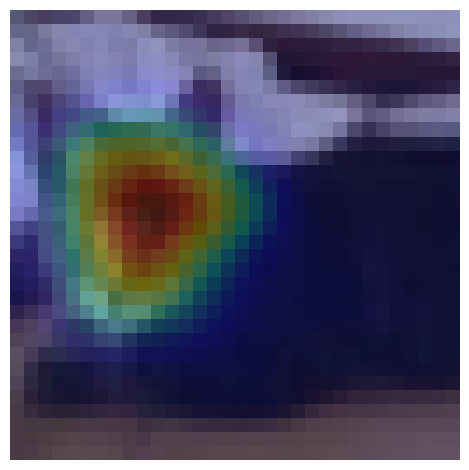

In [119]:
plt.imshow(result_nomoe); plt.axis('off'); plt.tight_layout(); plt.show()